<a href="https://colab.research.google.com/github/xazhu9/AIPI-590/blob/main/Assignment%20%2305.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

AIPI 590 - XAI | Assignment #05

Xuanang Zhu

Description: Select one black-box model(I chose the ResNet34), and use generate local explaination with visualization about its decision making process.



In [20]:
import lime
from lime import lime_image, lime_tabular, lime_text
import numpy as np
import matplotlib.pyplot as plt
import torchvision.models as models
import torch
from torchvision import transforms
from PIL import Image
from torch.utils.data import DataLoader
from torchvision import datasets
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt



In [21]:
# Define prediction
def predict_function(images):
    images = torch.stack([torch.Tensor(image).permute(2, 0, 1) for image in images], dim=0)  # LIME 提供的是扰动后的图像，需要转换格式
    outputs = model(images)
    return outputs.detach().numpy()

In [22]:
!rm -rf AIPI-590
!git clone https://github.com/xazhu9/AIPI-590.git

Cloning into 'AIPI-590'...
remote: Enumerating objects: 6090, done.
remote: Counting objects: 100% (86/86), done.
remote: Compressing objects: 100% (79/79), done.
remote: Total 6090 (delta 35), reused 24 (delta 7), pack-reused 6004 (from 1)
Receiving objects: 100% (6090/6090), 63.63 MiB | 26.49 MiB/s, done.
Resolving deltas: 100% (35/35), done.


In [23]:
pip install lime

Load datasets and model.

Data is the TinyImageNet we used for previous assignment to train patch.

The model is ResNet34 model, which is for image classification.

In [25]:
# load datasets
transform = transforms.Compose([
    transforms.Resize(224),  # change graph size
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder("/content/AIPI-590/TinyImageNet", transform=transform)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# load pre-trained ResNet34 model
model = models.resnet34(weights=True)
model.eval()

# define preprocess
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Choose one image to explain

In [26]:
data_iter = iter(data_loader)
images, labels = next(data_iter)

# Choose one image
input_image = images[0].unsqueeze(0)

Creat LIME explainer

In [27]:
explainer = lime_image.LimeImageExplainer()


# Generate explaination with LIME
explanation = explainer.explain_instance(np.array(images[0].permute(1, 2, 0)), predict_function, top_labels=5, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

Visualize explaination, helped by Chatgpt

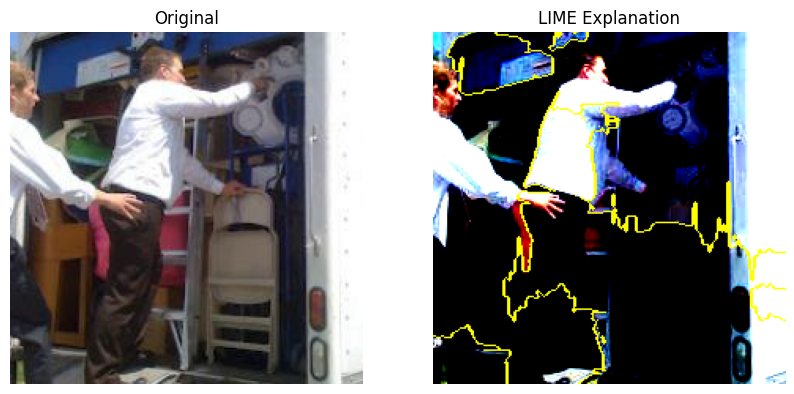

In [29]:
# Define the mean and standard deviation used for de-normalization
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# Get the model's prediction
model.eval()  # Ensure the model is in evaluation mode
output = model(images[0].unsqueeze(0))  # Get the prediction for a single image
predicted_class = torch.argmax(output, dim=1).item()  # Get the index of the predicted class

# Class name mapping (assuming you are using an ImageFolder dataset)
class_names = dataset.classes  # ImageFolder datasets typically contain class names
predicted_label = class_names[predicted_class]  # Get the predicted class name

# Get the LIME explanation result (temp and mask)
temp, mask = explanation.get_image_and_mask(label=predicted_class, positive_only=True, num_features=10, hide_rest=False)

# De-normalize the original image
image_data = images[0].permute(1, 2, 0).numpy()  # Convert image from CxHxW format to HxWxC format
image_data = std * image_data + mean  # Apply de-normalization
image_data = np.clip(image_data, 0, 1)  # Ensure the pixel values are within [0, 1]

# Ensure the image data is in float32 format with values in the range [0, 1]
image_data = image_data.astype(np.float32)  # Make sure the data type is float32

# Create a plot with 1 row and 2 columns, showing the original image and the LIME explanation
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Display the original image with the predicted class name in the title
ax[0].imshow(image_data)
ax[0].set_title(f"Original")  # Show the predicted class
ax[0].axis('off')  # Hide the axis

# Display the LIME explanation
ax[1].imshow(mark_boundaries(temp, mask))
ax[1].set_title("LIME Explanation")  # Display LIME explanation
ax[1].axis('off')  # Hide the axis

# Show the plot
plt.show()

Explainations:

LIME perturbe the image and see how the model's identification react to such chages on the pictures. LIME then collect such results as a new dataset, and fit the data to local model to find influencial features, in this case part of image. By visualize the result, LIME tells us which part of the picture is more influencial for the decision making by highlighting the part with yellow lines.

Why I Chose LIME:

I chose LIME because it’s a model-agnostic tool that can explain the predictions of any complex model. Specifically, for image classification tasks, LIME effectively highlights the regions the model focuses on, making it easier to understand the model’s decision-making process.

Strengths of LIME:

LIME Works with any model, from neural networks to decision trees and can provide clear, interpretable insights for individual predictions. In addition, it can be applied to images, text, and tabular and is able to provides intuitive visual explanations by highlighting key areas in images.

Limitations of LIME:

Lime only explains individual predictions, not the model’s global behavior and requires multiple data perturbations, which can be slow. It's also not stable since small changes in input can lead to different explanations.

One improvement that could be made is to explain with SHAP since it provides a more general explaination for the model as a whole. Combine such explaintion with LIME's explaination on individual would offer a more comprehensive result.